In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import ntpath 
import re 
import sys
import pickle
sys.path.append(r'../.')
from commons.data_processing import * 
from commons.my_mzml import *
from commons.DataProcessors.byonic import ByFile

In [2]:
# get byonic output files
files = get_files('.', exts=['.xlsx'])

# get xml files
xmls = get_files(r"D:\LocalData_temp\PGC_Parallel_Comp", exts=['.mzXML'])

In [3]:
# create pandas dataframe from byonic output of all runs 
all_runs = pd.DataFrame()
for file in files[:]:
    source, _ = ntpath.splitext(ntpath.basename(file))
    bf = ByFile(file)
    bf.fill_no_glycans()
    bf.remove_reverse(modify=True)
    bf.determine_glycosites()
    bf.filter_hits(score=200, modify=True)
    bf.frame = bf.reduce_frame(gp_only=True)
    bf.frame['source'] = [source]*len(bf.frame)
    bf.frame.sort_values('z', inplace=True)
    total = bf.total_gp()
    unique = bf.unique_gp()
    if all_runs.empty:
        all_runs = unique
    else:
        all_runs = pd.concat([all_runs, unique])

C:\Users\Graham Delafield\AppData\Local\Programs\Python\Python38\lib\site-packages\openpyxl\styles\stylesheet.py:214: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
../.\commons\byonic.py:162: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return self.frame[crit_1 & crit_2 & crit_3]


In [4]:
# pull example
all_runs[all_runs.peptide=='R.N[+1378.476]LTK.D']

,clean_peptide,glycan,z,observed_mz,calc._mass_mh,glycosite,score,delta_mod,log_prob,peptide,protein_name,scan_time,source
4349,NLTK,HexNAc(2)Hex(6),2.0,927.3910,1853.7632,61,212.19,212.19,2.75,R.N[+1378.476]LTK.D,>sp|P61823|RNAS1_BOVIN Ribonuclease pancreatic...,20.8223,BP_30C
4733,NLTK,HexNAc(2)Hex(6),2.0,927.3907,1853.7632,61,279.61,279.61,3.56,R.N[+1378.476]LTK.D,>sp|P61823|RNAS1_BOVIN Ribonuclease pancreatic...,19.0495,BP_45C
4856,NLTK,HexNAc(2)Hex(6),2.0,927.3909,1853.7632,61,251.99,251.99,4.37,R.N[+1378.476]LTK.D,>sp|P61823|RNAS1_BOVIN Ribonuclease pancreatic...,17.0746,BP_60C
7239,NLTK,HexNAc(2)Hex(6),2.0,927.3913,1853.7632,61,312.21,312.21,5.61,R.N[+1378.476]LTK.D,>sp|P61823|RNAS1_BOVIN Ribonuclease pancreatic...,6.0586,C18_30C
7123,NLTK,HexNAc(2)Hex(6),2.0,927.3907,1853.7632,61,376.08,376.08,6.49,R.N[+1378.476]LTK.D,>sp|P61823|RNAS1_BOVIN Ribonuclease pancreatic...,4.3907,C18_45C
7472,NLTK,HexNAc(2)Hex(6),2.0,927.3900,1853.7632,61,275.00,275.00,5.24,R.N[+1378.476]LTK.D,>sp|P61823|RNAS1_BOVIN Ribonuclease pancreatic...,5.4231,C18_60C
6160,NLTK,HexNAc(2)Hex(6),2.0,927.3879,1853.7632,61,420.78,420.78,5.70,R.N[+1378.476]LTK.D,>sp|P61823|RNAS1_BOVIN Ribonuclease pancreatic...,18.7389,PGC_30C
5205,NLTK,HexNAc(2)Hex(6),2.0,927.3874,1853.7632,61,349.66,349.66,4.59,R.N[+1378.476]LTK.D,>sp|P61823|RNAS1_BOVIN Ribonuclease pancreatic...,18.8446,PGC_45C
4887,NLTK,HexNAc(2)Hex(6),2.0,927.3885,1853.7632,61,281.43,281.43,3.71,R.N[+1378.476]LTK.D,>sp|P61823|RNAS1_BOVIN Ribonuclease pancreatic...,17.3871,PGC_60C


In [5]:
counts = all_runs.peptide.value_counts()
bpc = all_runs[all_runs.peptide.isin(counts[counts > 8].keys())]
bpc.head()


if os.path.exists('EnrGly_EICs_BPC.p'):
    d = pickle.load(open('EnrGly_EICs_BPC.p', 'rb'))
else:
    d = {}
    for r in bpc.peptide.unique():
        sub = bpc[bpc.peptide==r]
        s = {}
        s['sequence'] = sub.clean_peptide.unique()
        s['glycan'] = sub.glycan.unique()
        s['masses'] = sub.observed_mz.values
        s['charges'] = sub.z.values
        s['sources'] = sub.source.values
        s['times'] = sub.scan_time.values
        s['arrays'] = []
        d[r] = s

    for peptide in d:
        print(peptide)
        for i, source in enumerate(d[peptide]['sources']):
            file = [f for f in xmls if re.search(source, f)][0]
            m = mzXML(file)
            mass = d[peptide]['masses'][i]
            xs, ys = m.ms1_extract(mass, tolerance=10)
            d[peptide]['arrays'].append((xs, ys))
    pickle.dump(d, open('EnrGly_EICs_BPC.p', 'wb'))

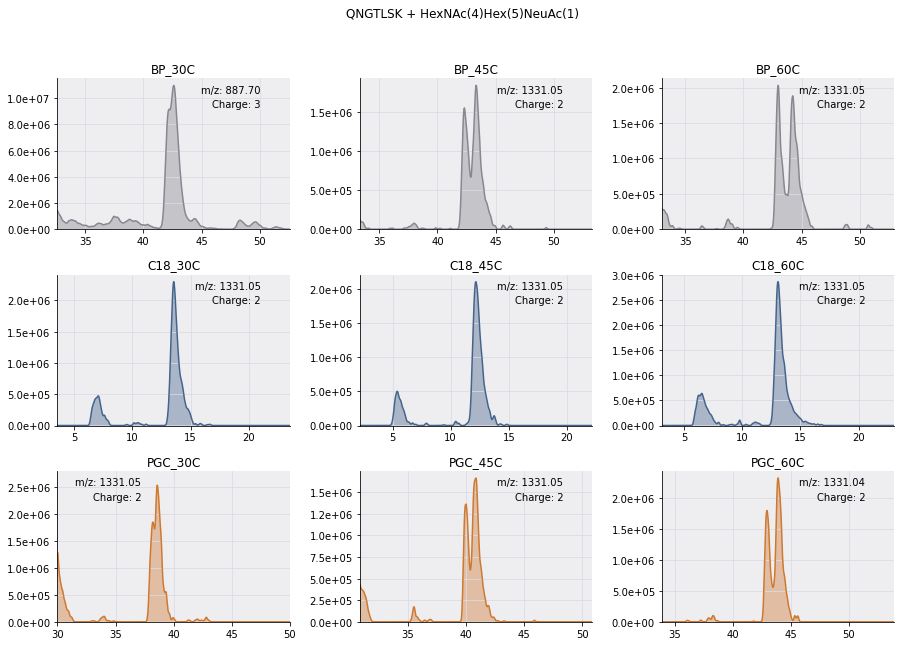

In [13]:
color_dict = {
    'BP':'#88868F',
    'C18':'#45648B',
    'PGC':'#CE7830'
}

for peptide in d:
    data = d[peptide]['arrays']
    masses = d[peptide]['masses']
    charges = d[peptide]['charges']
    sources = d[peptide]['sources']
    glycan = d[peptide]['glycan'][0]
    sequence = d[peptide]['sequence'][0]

    title = sequence + ' + ' + glycan

    fig, axs = plt.subplots(3, 3, figsize=(15,10))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    for i, ax in enumerate(axs.flat):
        arr = data[i]
        xs, ys = arr[0], arr[1]
        ys = gaussian_filter(ys, 2)
        idx = np.where(ys == np.max(ys))
        if sequence == 'QNGTLSK':
            if glycan == 'HexNAc(4)Hex(5)NeuAc(1)':
                if sources[i] == 'PGC_30C':
                    t_range = np.where(np.logical_and(xs >= 30, xs <= 50))
                else:
                    t_range = np.where(np.logical_and(xs >= xs[idx]-10, xs <= xs[idx]+10))
        else:
            t_range = np.where(np.logical_and(xs >= xs[idx]-10, xs <= xs[idx]+10))
        x, y = xs[t_range], ys[t_range]

        # ax = axs[i % 3][i // 3]
        # plot data
        ax = axs.flat[i]
        color = color_dict[sources[i].split('_')[0]]
        ax.plot(x, y, color=color)
        ax.fill_between(x, 0, y, facecolor=color, alpha=0.4)
        if sequence == 'QNGTLSK':
            if glycan == 'HexNAc(4)Hex(5)NeuAc(1)':
                if sources[i] == 'PGC_30C':
                    ax.set_xlim(30, 50)
                else:
                    ax.set_xlim(xs[idx]-10, xs[idx]+10)
        else:
            ax.set_xlim(xs[idx]-10, xs[idx]+10)
        ax.set_ylim(0, max(ys)*1.05)

        # add identifying text
        ax.set_title(sources[i])
        ax.text(xs[idx]+7.5, max(ys)*.95, f'm/z: {masses[i]:.2f}', ha='right')
        ax.text(xs[idx]+7.5, max(ys)*.85, f'Charge: {charges[i]}', ha='right')

        # format plots
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
        ax.set_facecolor('#EEEEF0')
        ax.grid(True, color='#dadbe6')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        fig.suptitle(title)
    fig.savefig('./MS1_Traces/BPC/'+title+'.png')
    fig.savefig('./MS1_Traces/BPC/'+title+'.svg')
    plt.close()

In [8]:
sources

array(['BP_30C', 'BP_45C', 'BP_60C', 'C18_30C', 'C18_45C', 'C18_60C',
       'PGC_30C', 'PGC_45C', 'PGC_60C'], dtype=object)

In [23]:
_sub = d['R.QN[+1913.677]GTLSK.V']
sources = _sub['sources']
arrays = _sub['arrays']

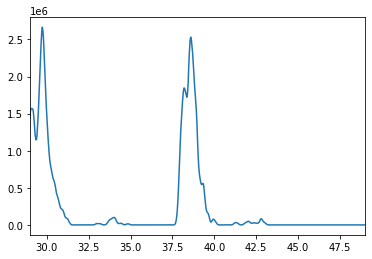

In [38]:
i = np.where(sources=='PGC_30C')[0][0]
x,y = arrays[i][0], arrays[i][1]
y = gaussian_filter(y, 2)
plt.plot(x, y)
plt.xlim(29, 49)
plt.savefig('TempMS1.svg')

In [40]:
m = mzXML(xmls[0])
x, y = m.ms1_extract(1331.05, tolerance=10)

(33.0, 53.0)

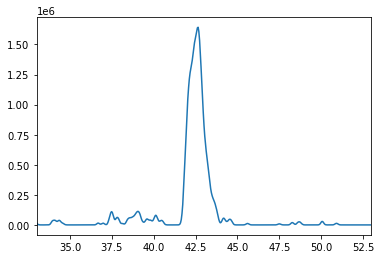

In [43]:
y = gaussian_filter(y, 2)
plt.plot(x, y)
plt.xlim(33, 53)